# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

## 2. Data Exploration Analysis
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, auc, roc_curve

import warnings
warnings.filterwarnings('ignore')

C:\Users\cfsui\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("data.csv") 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [3]:
from modules.missing_describe import md
md(df)

,dtype,missing_count,missing_percent
Credit_History,float64,50,0.081433
Self_Employed,object,32,0.052117
LoanAmount,float64,22,0.035831
Dependents,object,15,0.024430
Loan_Amount_Term,float64,14,0.022801
Gender,object,13,0.021173
Married,object,3,0.004886
Loan_ID,object,0,0.000000
Education,object,0,0.000000
ApplicantIncome,int64,0,0.000000


Look at some basic statistics for numerical variables.

Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)
2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?
3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.



In [4]:
# reset dtypes
cat_cols = ['Loan_ID', 'Gender', 'Married', 'Dependents',	'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']
df[cat_cols] = df[cat_cols].astype('category')
df.dtypes

Loan_ID              category
Gender               category
Married              category
Dependents           category
Education            category
Self_Employed        category
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History       category
Property_Area        category
Loan_Status          category
dtype: object

In [5]:
# seperate numeric and categorical columns
df_cat = df[cat_cols]
df_num = df.select_dtypes(exclude='category')

# check numeric columns
df_num.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


In [6]:
# check unique values of categorical columns (exclude id)
for col in df_cat.columns[1:]:
    print(df_cat[col].value_counts(), '\n')

Male      489
Female    112
Name: Gender, dtype: int64 

Yes    398
No     213
Name: Married, dtype: int64 

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64 

Graduate        480
Not Graduate    134
Name: Education, dtype: int64 

No     500
Yes     82
Name: Self_Employed, dtype: int64 

1.0    475
0.0     89
Name: Credit_History, dtype: int64 

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64 

Y    422
N    192
Name: Loan_Status, dtype: int64 



### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



In [7]:
df_num.corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878
LoanAmount,0.570909,0.188619,1.000000,0.039447
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000


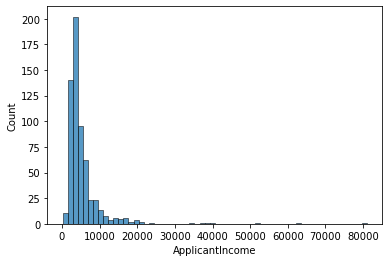

In [8]:
sns.histplot(df['ApplicantIncome'], bins=60)
plt.show()


Look at box plots to understand the distributions. 

Look at the distribution of income segregated  by `Education`

In [9]:
df_num.columns.size

4

In [10]:
df_cat = df_cat.drop(columns='Loan_ID')
df_cat.columns.size

8

In [11]:
df['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

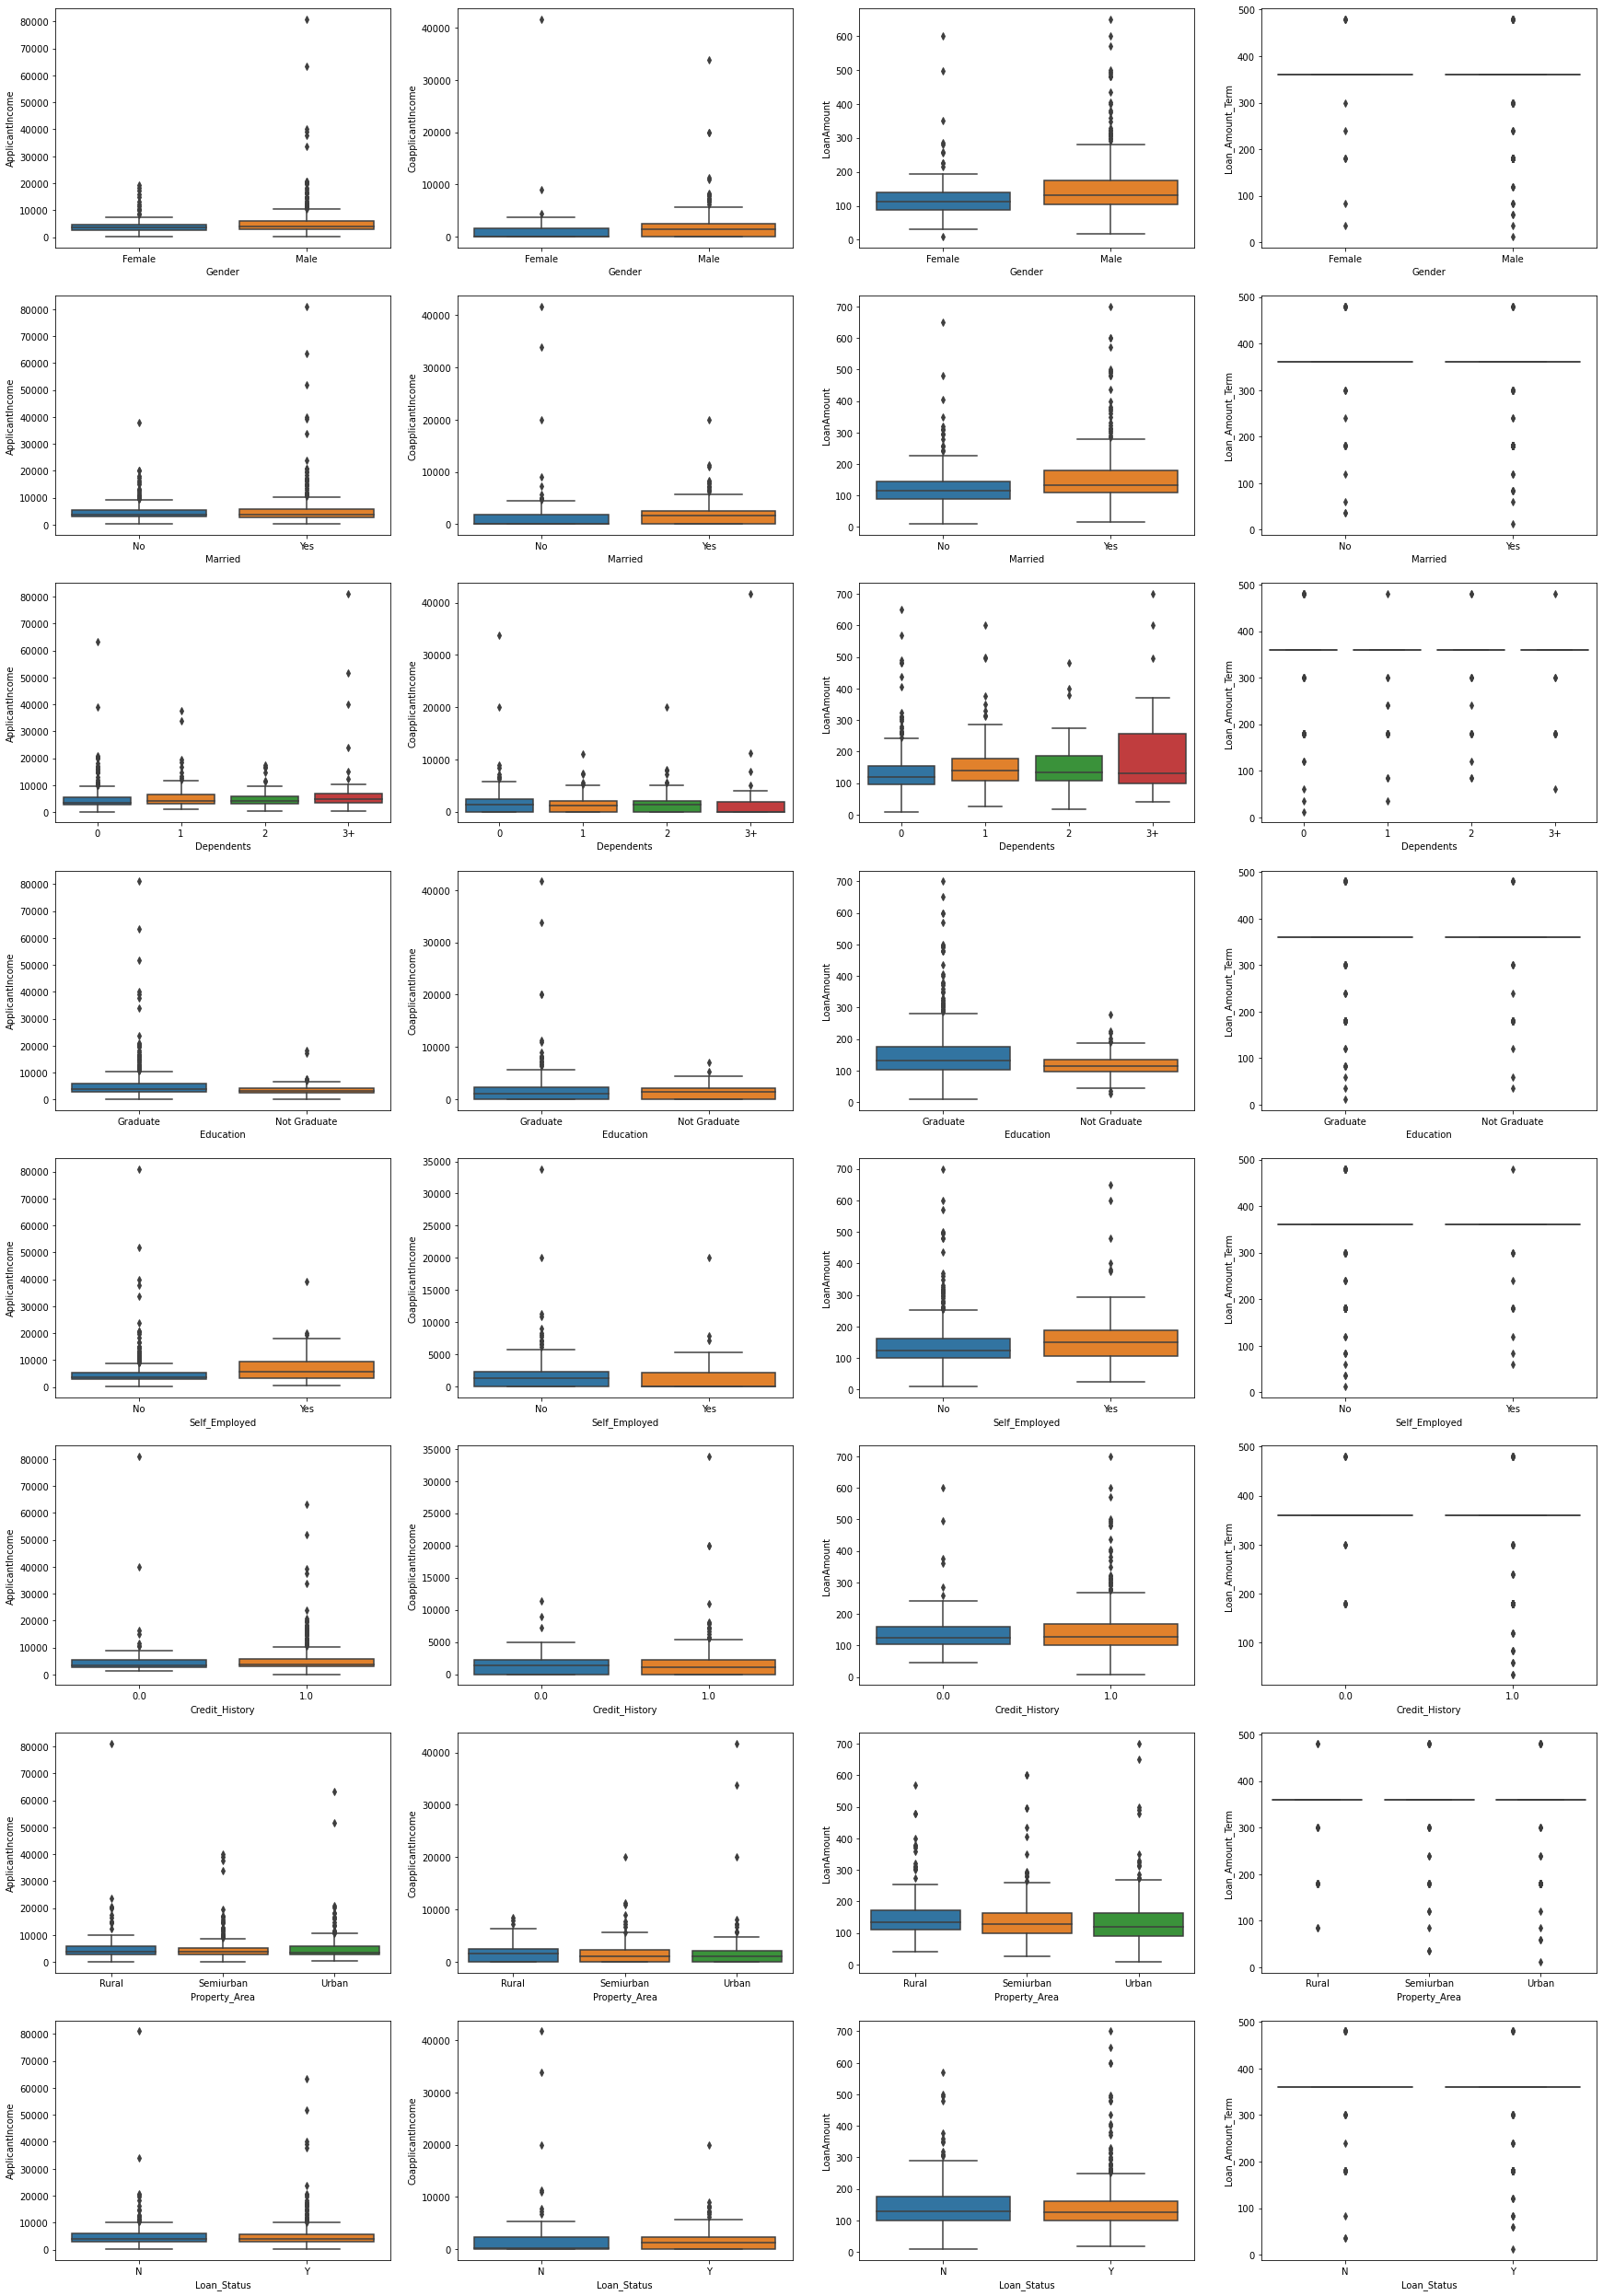

In [13]:
fig, axes = plt.subplots(8, 4, figsize=(30, 45))
for i in range(len(df_cat.columns)):
    for j in range(len(df_num.columns)):
        sns.boxplot(ax=axes[i,j], x=df_cat.columns[i], y=df_num.columns[j], data=df)
plt.show()

<AxesSubplot:xlabel='Loan_Status'>

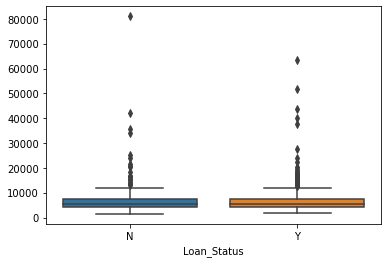

In [14]:
sns.boxplot(x=df['Loan_Status'], y=df['ApplicantIncome']+df['CoapplicantIncome'])

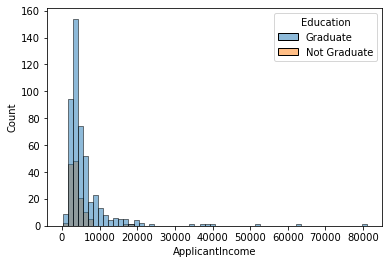

In [15]:
sns.histplot(x='ApplicantIncome', hue='Education', data=df, bins=60)
plt.show()

Look at the histogram and boxplot of LoanAmount

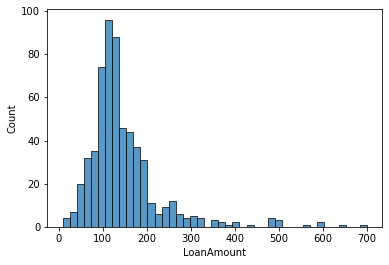

In [16]:
sns.histplot(data=df['LoanAmount'])
plt.show()

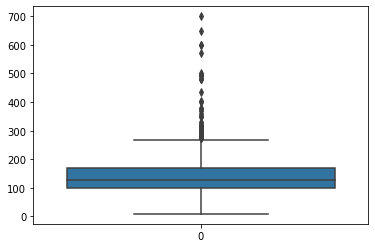

In [17]:
sns.boxplot(data=df['LoanAmount'])
plt.show()

In [16]:
# imbalance data

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical variable analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

In [17]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

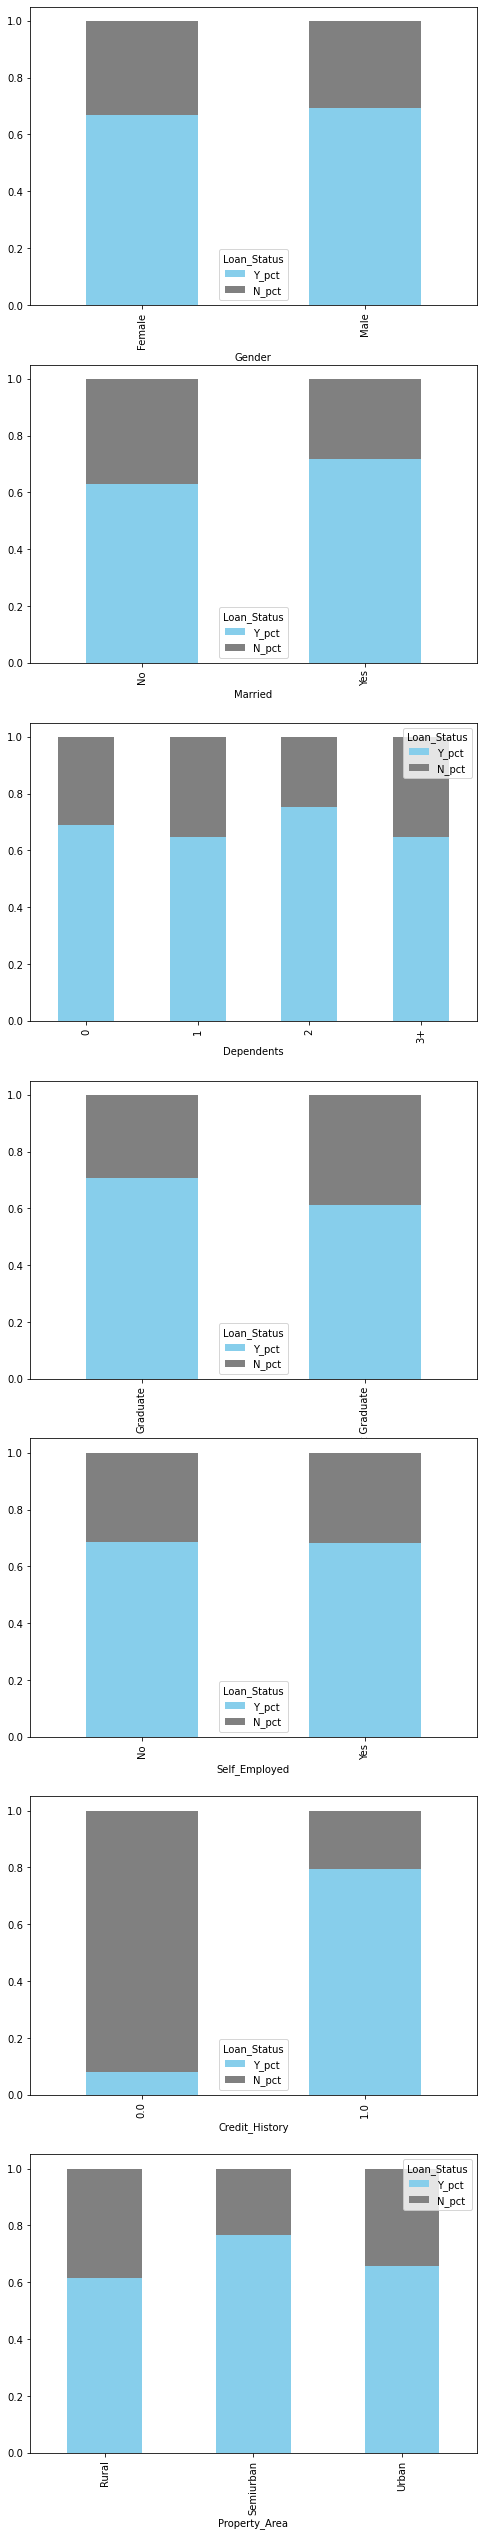

In [18]:
fig, axes = plt.subplots(7, figsize=(8, 45))
for i in range(len(df_cat.columns)-1):
    col = df_cat.columns[i]
    data = df[[col, 'Loan_Status']].groupby(col).value_counts().unstack()
    data['Y_pct'] = data['Y'] / (data['Y'] + data['N'])
    data['N_pct'] = 1 - data['Y_pct']
    data[['Y_pct', 'N_pct']].plot(ax=axes[i], kind='bar', stacked=True, color=['skyblue', 'grey'])

## 3. Data preprocessing

This step typically involves imputing missing values and treating outliers. 

### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

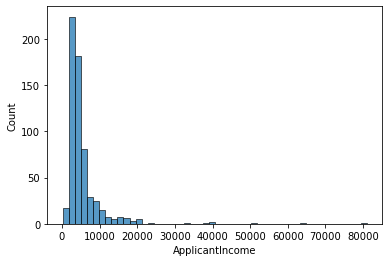

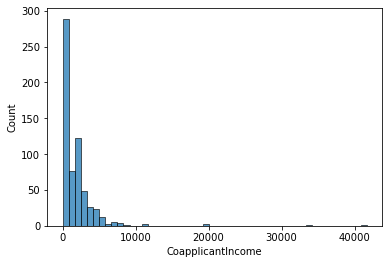

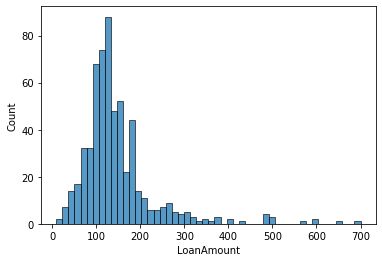

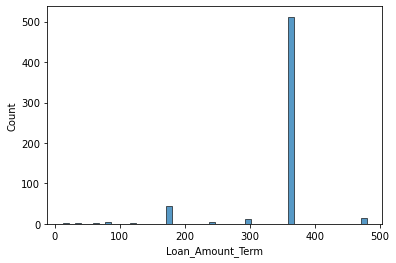

In [19]:
for col in df_num.columns:
    sns.histplot(data=df[col], bins=50)
    plt.show()

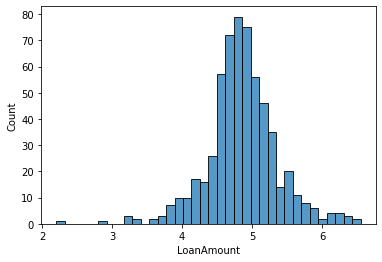

In [20]:
sns.histplot(data=np.log(df['LoanAmount']))
plt.show()

Combine both incomes as total income and take a log transformation of the same.

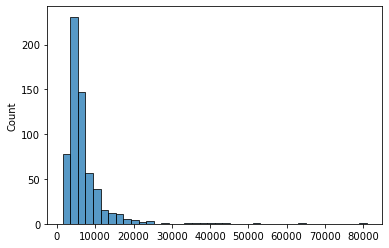

In [21]:
sns.histplot(data=df['ApplicantIncome'] + df['CoapplicantIncome'], bins=40)
plt.show()

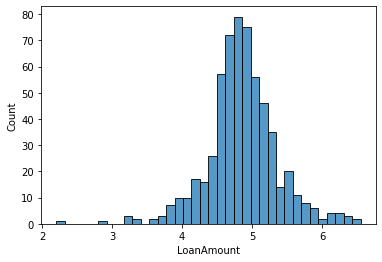

In [22]:
sns.histplot(data=np.log(df['LoanAmount']))
plt.show()

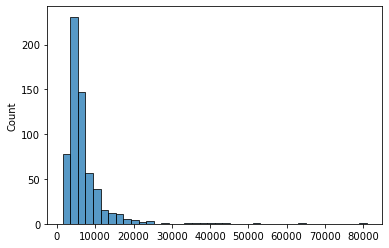

In [111]:
sns.histplot(data=df['ApplicantIncome'] + df['CoapplicantIncome'], bins=40)
plt.show()

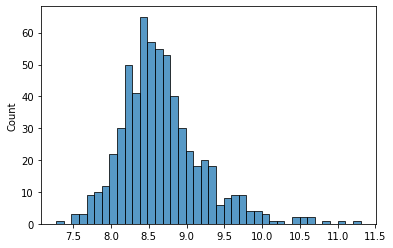

In [23]:
sns.histplot(data=np.log(df['ApplicantIncome'] + df['CoapplicantIncome']), bins=40)
plt.show()

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [24]:
train, test = train_test_split(df, test_size=0.3, random_state=88)
test.to_csv('test.csv')

X_train = train.drop(columns=['Loan_ID', 'Loan_Status'])
y_train = train['Loan_Status']

In [25]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
159,Male,Yes,0,Graduate,No,4583,5625.0,255.0,360.0,1.0,Semiurban
563,Male,No,0,Not Graduate,Yes,5800,0.0,132.0,360.0,1.0,Semiurban
404,Female,No,0,Graduate,Yes,7441,0.0,194.0,360.0,1.0,Rural
329,Female,No,0,Graduate,No,2500,0.0,67.0,360.0,1.0,Urban
266,Male,Yes,2,Graduate,No,4708,1387.0,150.0,360.0,1.0,Semiurban


In [26]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [27]:
X_train.dtypes

Gender               category
Married              category
Dependents           category
Education            category
Self_Employed        category
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History       category
Property_Area        category
dtype: object

In [28]:
# from sklearn.base import BaseEstimator, TransformerMixin
# class feature_engineer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         pass
    
#     def transform(self, X, y=None):
#         # Sum the applicant and coapplicant income as total income
#         X['TotalIncome'] = X['ApplicantIncome'] + X['CoapplicantIncome']
#         # calculate montly loan payment
#         X['MonthlyPay'] = X['LoanAmount'] * 1000  / X['Loan_Amount_Term']
#         # monthly balance
#         X['MonthlyBalance'] = X['TotalIncome'] - X['MonthlyPay']
#         # drop useless columns
#         X = X.drop(columns=['ApplicantIncome', 'CoapplicantIncome'])
#         # tranform skew-distributed columns by np.log
#         cols_log = ['TotalIncome', 'LoanAmount', 'MonthlyPay', 'MonthlyBalance']
#         df[cols_log] = np.log(df[cols_log])

#         return df
    
#     def fit_transform(self, X, y=None):
#         self.fit(X)
#         return self.transform(X)

from feature_engineer import feature_engineer
X_train = feature_engineer(X_train)
X_train.head()
# num_feats = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
# nominal_feats = ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History']
# ordinal_feats = ['Dependents', 'Property_Area']

# Dependents_order = ['0', '1', '2', '3+']
# Property_Area_order = ['Rural', 'Semiurban', 'Urban']

# feature_engineer = ColumnTransformer([('feature_engineer', feature_engineer())])

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalIncome,MonthlyPay,MonthlyBalance
159,Male,Yes,0,Graduate,No,5.541264,360.0,1.0,Semiurban,9.230927,6.562915,9.159012
563,Male,No,0,Not Graduate,Yes,4.882802,360.0,1.0,Semiurban,8.665613,5.904453,8.600308
404,Female,No,0,Graduate,Yes,5.267858,360.0,1.0,Rural,8.914761,6.289509,8.839583
329,Female,No,0,Graduate,No,4.204693,360.0,1.0,Urban,7.824046,5.226344,7.746685
266,Male,Yes,2,Graduate,No,5.010635,360.0,1.0,Semiurban,8.715224,6.032287,8.644413


In [29]:
num_feats = ['LoanAmount', 'Loan_Amount_Term', 'TotalIncome', 'MonthlyPay', 'MonthlyBalance']
nominal_feats = ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History']
ordinal_feats = ['Dependents', 'Property_Area']

Dependents_order = ['0', '1', '2', '3+']
Property_Area_order = ['Rural', 'Semiurban', 'Urban']


# impute mean value for numeric cols; standardize
numeric_transform = Pipeline([('scaling', StandardScaler()),
                              ('impute_mean', SimpleImputer(strategy='mean')), 
                              ('pca', PCA())])
# impute mode value for nominal cols; OHE
nominal_transform = Pipeline([('impute_mode', SimpleImputer(strategy='most_frequent')), 
                              ('OHE', OneHotEncoder(sparse=False))])
# impute mode value for ordinal cols; ordinal encoding
ordinal_transform = Pipeline([('impute_mode', SimpleImputer(strategy='most_frequent')), 
                              ('ordinal_encoding', OrdinalEncoder(categories=[Dependents_order, Property_Area_order]))])

# parallel transform numeric, nominal and ordinal columns
preprocessing = ColumnTransformer([('numeric', numeric_transform, num_feats), 
                                   ('nominal', nominal_transform, nominal_feats), 
                                   ('ordinal', ordinal_transform, ordinal_feats)])

## 4. Building a Predictive Model by Using Pipeline

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

Try paramater grid search to improve the results

In [30]:
pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                           ('classifier', RandomForestClassifier(random_state=88, max_depth=3, n_estimators=50))])
pipeline.fit(X_train, y_train)

# def permutation_importances(rf, X_train, y_train, metric):
#     baseline = metric(rf, X_train, y_train)
#     imp = []
#     for col in X_train.columns:
#         save = X_train[col].copy()
#         X_train[col] = np.random.permutation(X_train[col])
#         m = metric(rf, X_train, y_train)
#         X_train[col] = save
#         imp.append(baseline - m)
#     return np.array(imp)

# permutation_importances(pipeline, X_train, y_train, oob_)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler()),
                                                                  ('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('pca',
                                                                   PCA())]),
                                                  ['LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'TotalIncome', 'MonthlyPay',
                                                   'MonthlyBalance']),
                                                 ('nominal',
                                                  Pipeline(steps=[('impute_

In [31]:
nominal = list(pipeline.named_steps['preprocessing'].named_transformers_['nominal'].named_steps['OHE'].get_feature_names(input_features=nominal_feats))
feats = num_feats + nominal + ordinal_feats
feats

['LoanAmount',
 'Loan_Amount_Term',
 'TotalIncome',
 'MonthlyPay',
 'MonthlyBalance',
 'Gender_Female',
 'Gender_Male',
 'Married_No',
 'Married_Yes',
 'Education_Graduate',
 'Education_Not Graduate',
 'Self_Employed_No',
 'Self_Employed_Yes',
 'Credit_History_0.0',
 'Credit_History_1.0',
 'Dependents',
 'Property_Area']

In [32]:
importance = pipeline.steps[1][1].feature_importances_
importance

array([0.03276626, 0.06526886, 0.06276057, 0.06422057, 0.04246694,
       0.00150974, 0.00564427, 0.01048821, 0.00555778, 0.01215941,
       0.00504157, 0.00485853, 0.00142436, 0.27585841, 0.39915651,
       0.00665687, 0.00416114])

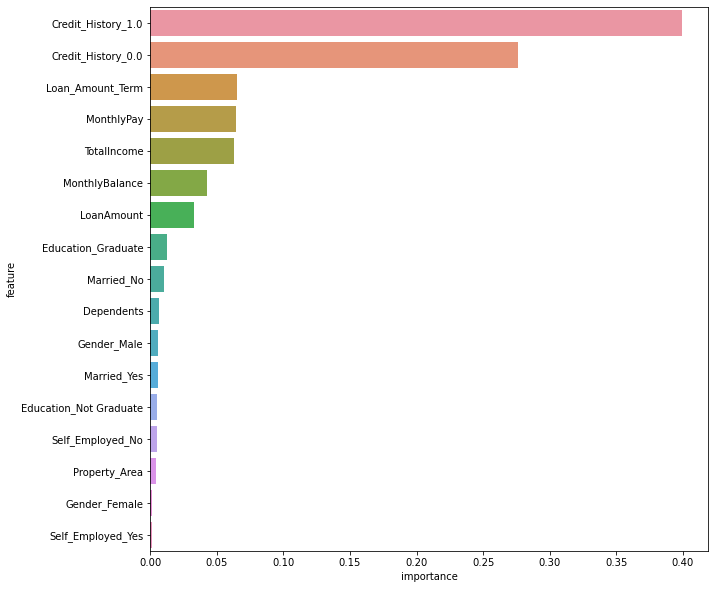

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
feats_importance = pd.DataFrame({'feature': feats, 'importance': importance}).sort_values(by='importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feats_importance)
plt.show()

In [86]:
# Find the best hyperparameters and model using GridSearchCV on the train set
classifiers = [LogisticRegression(), RidgeClassifier(), KNeighborsClassifier(), SVC(), GaussianNB(), BaggingClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
param_grid = [{'classifier': [classifiers],
               'preprocessing__numeric__pca__n_components': [1,2,3]}
              ,
              {'classifier': [LogisticRegression()],
               'classifier__penalty': ['l1', 'l2'],
               'classifier__C': [100, 10, 1.0, 0.5, 0.1, 0.01]}
              , 
              {'classifier': [RidgeClassifier()],
               'classifier__alpha': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
              , 
              {'classifier': [KNeighborsClassifier()],
               'classifier__n_neighbors': range(1, 21, 2),
               'classifier__weights': ['uniform', 'distance'],
               'classifier__metric': ['euclidean', 'manhattan', 'minkowski']}
              ,
              {'classifier': [SVC()],
               'classifier__kernel': ['poly', 'rbf', 'sigmoid'],
               'classifier__C': [50, 10, 1.0, 0.1, 0.01],
               'classifier__gamma': ['scale']}
              ,
              {'classifier': [BaggingClassifier()], 
               'classifier__n_estimators': [50, 100, 300, 500]}
              ,
              {'classifier': [GaussianNB()]}
              ,
              {'classifier': [RandomForestClassifier()],
               'classifier__n_estimators': [50, 100, 300, 500],
               'classifier__max_features': ['sqrt', 'log2']}
              ,
              {'classifier': [GradientBoostingClassifier()],
               'classifier__n_estimators': [50, 100, 300, 500], 
               'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1],
               'classifier__subsample': [0.5, 0.7, 1.0],
               'classifier__max_depth': [3, 7, 9]}]

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaling',
                                                                                          StandardScaler()),
                                                                                         ('impute_mean',
                                                                                          SimpleImputer()),
                                                                                         ('pca',
                                                                                          PCA())]),
                                                                         ['LoanAmount',
                                                                          'Loan_Amount_Term',
                                      

In [87]:
grid.best_params_

{'classifier': GradientBoostingClassifier(n_estimators=50, subsample=0.5),
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 50,
 'classifier__subsample': 0.5}

In [88]:
grid.best_score_

0.811217510259918

In [89]:
X_test = feature_engineer(test.drop(columns=['Loan_ID', 'Loan_Status']))
y_test = test['Loan_Status']
y_pred = grid.predict(X_test)

In [90]:
accuracy_score(y_test, y_pred)

0.8432432432432433

In [97]:
confusion_matrix(y_test, y_pred)

array([[ 35,  24],
       [  5, 121]], dtype=int64)

In [98]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(35, 24, 5, 121)

In [107]:
scores = grid.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_num, scores, pos_label=1)

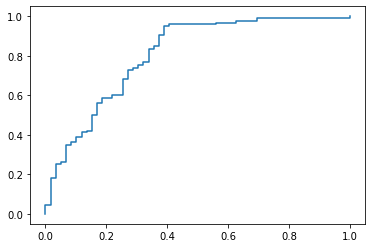

In [108]:
plt.plot(fpr, tpr)

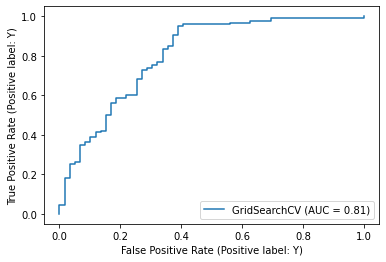

In [109]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(grid, X_test, y_test)

## 5. Deploy your model to cloud and test it with PostMan, BASH or Python

In [35]:
X_test = feature_engineer(test.drop(columns=['Loan_ID', 'Loan_Status']))
y_test = test['Loan_Status']
y_pred = pipeline.predict(X_test)

In [36]:
accuracy_score(y_test, y_pred)

0.8108108108108109

In [57]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(27, 32, 3, 123)

In [70]:
y_test_num = y_test.replace(['Y', 'N'], [1, 0])

In [73]:
rf_scores = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_num, rf_scores, pos_label=1)

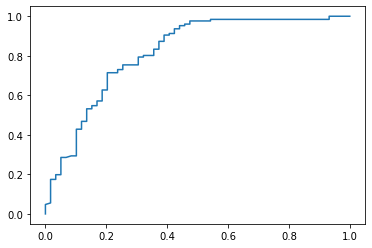

In [74]:
plt.plot(fpr, tpr)

In [55]:
import pickle
pickle.dump(pipeline, open('model.p', 'wb') )

In [40]:
from imblearn.over_sampling import SMOTE

In [47]:
X_train2 = preprocessing.fit_transform(X_train)

In [48]:
# transform the dataset
oversample = SMOTE()
X_train2, y_train2 = oversample.fit_resample(X_train2, y_train)

In [102]:
y_train2.value_counts()

N    296
Y    296
Name: Loan_Status, dtype: int64

In [50]:
rf2 = RandomForestClassifier(random_state=88, max_depth=3, n_estimators=50)
rf2.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=3, n_estimators=50, random_state=88)

In [51]:
X_test2 = preprocessing.fit_transform(X_test)
y_pred2 = rf2.predict(X_test2)

In [54]:
accuracy_score(y_test, y_pred2)

0.8108108108108109

In [79]:
confusion_matrix(y_test, y_pred2)

array([[ 27,  32],
       [  3, 123]], dtype=int64)

In [85]:
y_pred2_num = pd.DataFrame(y_pred2).replace(['Y', 'N'], [1, 0])
recall_score(y_test_num, y_pred2_num)

0.9761904761904762

In [103]:
gb = GradientBoostingClassifier(n_estimators=50, subsample=0.5, learning_rate=0.1, max_depth=3)
gb.fit(X_train2, y_train2)

GradientBoostingClassifier(n_estimators=50, subsample=0.5)

In [104]:
confusion_matrix(y_test, gb.predict(X_test2))

array([[ 36,  23],
       [ 13, 113]], dtype=int64)